In [47]:
import requests,os,time
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from tqdm import tqdm_notebook as tqdm

In [38]:
### Define our Connector

def ratelimit(dt):
    "A function that handles the rate of your calls."
    time.sleep(dt) # sleep one second.

class Connector():
  def __init__(self,logfile,overwrite_log=False,connector_type='requests',session=False,path2selenium='',n_tries = 5,timeout=30,waiting_time=0.5):
    """This Class implements a method for reliable connection to the internet and monitoring. 
    It handles simple errors due to connection problems, and logs a range of information for basic quality assessments
    
    Keyword arguments:
    logfile -- path to the logfile
    overwrite_log -- bool, defining if logfile should be cleared (rarely the case). 
    connector_type -- use the 'requests' module or the 'selenium'. Will have different since the selenium webdriver does not have a similar response object when using the get method, and monitoring the behavior cannot be automated in the same way.
    session -- requests.session object. For defining custom headers and proxies.
    path2selenium -- str, sets the path to the geckodriver needed when using selenium.
    n_tries -- int, defines the number of retries the *get* method will try to avoid random connection errors.
    timeout -- int, seconds the get request will wait for the server to respond, again to avoid connection errors.
    """
    
    ## Initialization function defining parameters. 
    self.n_tries = n_tries # For avoiding triviel error e.g. connection errors, this defines how many times it will retry.
    self.timeout = timeout # Defining the maximum time to wait for a server to response.
    self.waiting_time = waiting_time # define simple rate_limit parameter.
    ## not implemented here, if you use selenium.
    if connector_type=='selenium':
      assert path2selenium!='', "You need to specify the path to you geckodriver if you want to use Selenium"
      from selenium import webdriver 
      ## HIN download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases

      assert os.path.isfile(path2selenium),'You need to insert a valid path2selenium the path to your geckodriver. You can download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases'
      self.browser = webdriver.Firefox(executable_path=path2selenium) # start the browser with a path to the geckodriver.

    self.connector_type = connector_type # set the connector_type
    
    if session: # set the custom session
      self.session = session
    else:
      self.session = requests.session()
    self.logfilename = logfile # set the logfile path
    ## define header for the logfile
    header = ['id','project','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
    if os.path.isfile(logfile):        
      if overwrite_log==True:
        self.log = open(logfile,'w')
        self.log.write(';'.join(header))
      else:
        self.log = open(logfile,'a')
    else:
      self.log = open(logfile,'w')
      self.log.write(';'.join(header))
    ## load log 
    with open(logfile,'r') as f: # open file
        
      l = f.read().split('\n') # read and split file by newlines.
      ## set id
      if len(l)<=1:
        self.id = 0
      else:
        self.id = int(l[-1][0])+1
            
  def get(self,url,project_name):
    """Method for connector reliably to the internet, with multiple tries and simple error handling, as well as default logging function.
    Input url and the project name for the log (i.e. is it part of mapping the domain, or is it the part of the final stage in the data collection).
    
    Keyword arguments:
    url -- str, url
    project_name -- str, Name used for analyzing the log. Use case could be the 'Mapping of domain','Meta_data_collection','main data collection'. 
    """
     
    project_name = project_name.replace(';','-') # make sure the default csv seperator is not in the project_name.
    if self.connector_type=='requests': # Determine connector method.
      for _ in range(self.n_tries): # for loop defining number of retries with the requests method.
        ratelimit(self.waiting_time)
        t = time.time()
        try: # error handling 
          response = self.session.get(url,timeout = self.timeout) # make get call

          err = '' # define python error variable as empty assumming success.
          success = True # define success variable
          redirect_url = response.url # log current url, after potential redirects 
          dt = t - time.time() # define delta-time waiting for the server and downloading content.
          size = len(response.text) # define variable for size of html content of the response.
          response_code = response.status_code # log status code.
          ## log...
          call_id = self.id # get current unique identifier for the call
          self.id+=1 # increment call id
          #['id','project_name','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row to be written in the log.
          self.log.write('\n'+';'.join(map(str,row))) # write log.
          self.log.flush()
          return response,call_id # return response and unique identifier.

        except Exception as e: # define error condition
          err = str(e) # python error
          response_code = '' # blank response code 
          success = False # call success = False
          size = 0 # content is empty.
          redirect_url = '' # redirect url empty 
          dt = t - time.time() # define delta t

          ## log...
          call_id = self.id # define unique identifier
          self.id+=1 # increment call_id

          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row
          self.log.write('\n'+';'.join(map(str,row))) # write row to log.
          self.log.flush()
    else:
      t = time.time()
      ratelimit(self.waiting_time)
      self.browser.get(url) # use selenium get method
      ## log
      call_id = self.id # define unique identifier for the call. 
      self.id+=1 # increment the call_id
      err = '' # blank error message
      success = '' # success blank
      redirect_url = self.browser.current_url # redirect url.
      dt = t - time.time() # get time for get method ... NOTE: not necessarily the complete load time.
      size = len(self.browser.page_source) # get size of content ... NOTE: not necessarily correct, since selenium works in the background, and could still be loading.
      response_code = '' # empty response code.
      row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row 
      self.log.write('\n'+';'.join(map(str,row))) # write row to log file.
      self.log.flush()
    # Using selenium it will not return a response object, instead you should call the browser object of the connector.
    ## connector.browser.page_source will give you the html.
      return None,call_id

In [39]:
logfile = 'uk_police_scrape.csv'## name your log file.
connector = Connector(logfile, overwrite_log=True)

In [48]:
#Extract police force data
url = 'https://data.police.uk/api/forces'
response,call_id = connector.get(url,'forces')
Forces = pd.DataFrame(response.json())
Forces.head()

id                            name
0  avon-and-somerset  Avon and Somerset Constabulary
1       bedfordshire             Bedfordshire Police
2     cambridgeshire     Cambridgeshire Constabulary
3           cheshire           Cheshire Constabulary
4     city-of-london           City of London Police

In [41]:
len(Forces)

44

In [43]:
base_url = 'https://data.police.uk/api/stops-force?force='
dates = pd.date_range('2018-07','2018-10' , freq='1M')
dates = [d.strftime('%Y-%m') for d in dates]
List = []

for j in tqdm(Forces.id):
    for i in dates:
        url = base_url + j +'&date='+i
        response,call_id = connector.get(url,'stops')
        response.text
        jason = response.json()
        data = pd.DataFrame(jason)
        data['Force'] = j
        List.append(data)

In [82]:
Data = pd.concat(List, sort=False).reset_index(drop=True)
Data

<class 'str'>


age_range                   datetime  gender involved_person  \
0         18-24  2018-07-24T15:00:00+00:00    Male            True   
1          None  2018-07-22T00:00:00+00:00    None           False   
2          None  2018-07-15T16:00:00+00:00    None           False   
3          None  2018-07-30T00:00:00+00:00    None           False   
4       over 34  2018-07-26T08:45:00+00:00    Male            True   
5         10-17  2018-07-21T19:22:00+00:00    Male            True   
6          None  2018-07-16T17:15:00+00:00  Female            True   
7         18-24  2018-07-16T17:15:00+00:00  Female            True   
8         25-34  2018-07-07T00:15:00+00:00    Male            True   
9         18-24  2018-07-16T17:15:00+00:00  Female            True   
10        18-24  2018-07-07T00:15:00+00:00    Male            True   
11        18-24  2018-07-16T17:15:00+00:00  Female            True   
12        10-17  2018-07-12T20:30:00+00:00    Male            True   
13        10-17  2018-07-12T19:45:00+00:00    Male            True   
14      over 34  2018-07-11T03:30:00+00:00    Male            True   
15        18-24  2018-07-30T19:30:00+00:00    Male            True   
16        25-34  2018-07-26T11:40:00+00:00    Male            True   
17        18-24  2018-07-30T19:20:00+00:00    Male            True   
18        18-24  2018-07-05T05:45:00+00:00    Male            True   
19      over 34  2018-07-10T01:15:00+00:00    Male            True   
20         None  2018-07-03T01:04:00+00:00    Male            True   
21      over 34  2018-07-05T09:35:00+00:00    Male            True   
22        25-34  2018-07-14T03:30:00+00:00    Male            True   
23      over 34  2018-07-05T09:40:00+00:00  Female            True   
24      over 34  2018-07-10T11:10:00+00:00    Male            True   
25        18-24  2018-07-03T01:00:00+00:00    Male            True   
26      over 34  2018-07-03T09:35:00+00:00    Male            True   
27      over 34  2018-07-03T09:35:00+00:00    Male            True   
28      over 34  2018-07-16T11:50:00+00:00    Male            True   
29        10-17  2018-07-30T00:00:00+00:00    Male            True   
...         ...                        ...     ...             ...   
76980     18-24  2018-09-22T23:13:00+00:00  Female            True   
76981   over 34  2018-09-22T23:30:00+00:00  Female            True   
76982      None  2018-09-22T23:45:00+00:00    Male            True   
76983      None  2018-09-22T23:55:00+00:00  Female            True   
76984     18-24  2018-09-23T17:55:00+00:00    Male            True   
76985     10-17  2018-09-23T17:55:00+00:00    Male            True   
76986     10-17  2018-09-23T17:55:00+00:00    Male            True   
76987     10-17  2018-09-23T21:20:00+00:00    Male            True   
76988   over 34  2018-09-23T23:15:00+00:00    Male            True   
76989     18-24  2018-09-24T13:55:00+00:00    Male            True   
76990   over 34  2018-09-25T02:26:00+00:00  Female            True   
76991   over 34  2018-09-25T02:26:00+00:00    Male            True   
76992     25-34  2018-09-25T19:25:00+00:00    Male            True   
76993     18-24  2018-09-25T22:00:00+00:00  Female            True   
76994     18-24  2018-09-27T23:52:00+00:00    Male            True   
76995     18-24  2018-09-28T03:40:00+00:00    Male            True   
76996     18-24  2018-09-28T03:45:00+00:00    Male            True   
76997     18-24  2018-09-28T03:45:00+00:00    Male            True   
76998     18-24  2018-09-28T22:20:00+00:00    Male            True   
76999     10-17  2018-09-28T22:30:00+00:00    Male            True   
77000     10-17  2018-09-28T22:35:00+00:00    Male            True   
77001     10-17  2018-09-29T18:15:00+00:00    Male            True   
77002     18-24  2018-09-29T18:30:00+00:00    Male            True   
77003     10-17  2018-09-29T18:30:00+00:00  Female            True   
77004     18-24  2018-09-29T18:56:00+00:00    Male            True   
77005     10-17 

In [136]:
# Load the LOG
log_df = pd.read_csv('uk_police_scrape.csv',sep=';') # load the ;-separated log 


In [146]:
log_df.head(5)

id project connector_type             t   delta_t  \
0   0     job       requests  1.566392e+09 -0.219953   
1   1     job       requests  1.566392e+09 -0.099942   
2   2     job       requests  1.566392e+09 -0.091990   
3   3     job       requests  1.566392e+09 -0.083862   
4   4     job       requests  1.566392e+09 -0.063961   

                                                 url  \
0                  https://data.police.uk/api/forces   
1  https://data.police.uk/api/stops-force?force=a...   
2  https://data.police.uk/api/stops-force?force=a...   
3  https://data.police.uk/api/stops-force?force=a...   
4  https://data.police.uk/api/stops-force?force=a...   

                                        redirect_url  response_size  \
0                  https://data.police.uk/api/forces           2258   
1  https://data.police.uk/api/stops-force?force=a...         336662   
2  https://data.police.uk/api/stops-force?force=a...         317843   
3  https://data.police.uk/api/stops-force?force=a...         269735   
4  https://data.police.uk/api/stops-force?force=a...         263665   

   response_code  success  error                            dt  \
0            200     True    NaN 2019-08-21 12:49:44.175920486   
1            200     True    NaN 2019-08-21 12:49:46.607205391   
2            200     True    NaN 2019-08-21 12:49:47.231032372   
3            200     True    NaN 2019-08-21 12:49:47.874979258   
4            200     True    NaN 2019-08-21 12:49:48.518721581   

                      dt_minute                       dt_hour  
0 2019-08-21 12:49:00.000000486 2019-08-21 12:00:00.000000486  
1 2019-08-21 12:49:00.000000391 2019-08-21 12:00:00.000000391  
2 2019-08-21 12:49:00.000000372 2019-08-21 12:00:00.000000372  
3 2019-08-21 12:49:00.000000258 2019-08-21 12:00:00.000000258  
4 2019-08-21 12:49:00.000000581 2019-08-21 12:00:00.000000581

In [138]:
# Convert the time column 't' to datetime 
#log_df['dt'] = log_df.t.apply(datetime.datetime.fromtimestamp)
log_df['dt'] = pd.to_datetime(log_df.t,unit='s')

In [139]:
dt = log_df.dt.values[0]

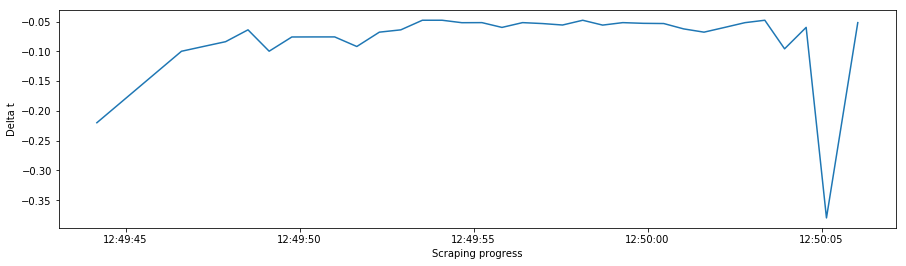

In [140]:
# Plot the time it took to make the call
plt.figure(figsize=(15,4))
plt.plot(log_df.dt,log_df.delta_t)
plt.ylabel('Delta t')
plt.xlabel('Scraping progress')


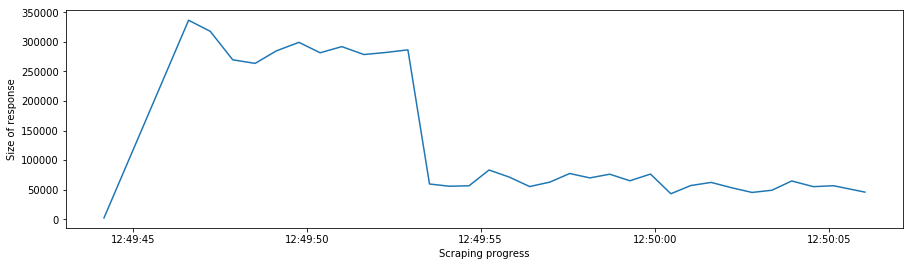

In [141]:
# Plot the response size over time.
plt.figure(figsize=(15,4))
plt.ylabel('Size of response')
plt.xlabel('Scraping progress')
plt.plot(log_df.dt,log_df.response_size)

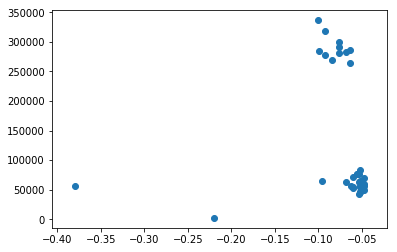

In [143]:
# Plot the delta_t against the response_size. These two should correlate pretty well.
plt.scatter(log_df.delta_t,log_df.response_size)

In [144]:
## Investigate errors
log_df.success.value_counts() ## Count errors
## Groupby time
# round the time for aggregation
log_df['dt_minute'] = log_df.dt.apply(lambda x: x-datetime.timedelta(seconds=x.second,microseconds=x.microsecond))
log_df['dt_hour'] = log_df.dt.apply(lambda x: x-datetime.timedelta(minutes=x.minute,seconds=x.second,microseconds=x.microsecond))
log_df.groupby('dt_hour').success.mean()

dt_hour
2019-08-21 12:00:00.000000045    True
2019-08-21 12:00:00.000000152    True
2019-08-21 12:00:00.000000172    True
2019-08-21 12:00:00.000000186    True
2019-08-21 12:00:00.000000209    True
2019-08-21 12:00:00.000000230    True
2019-08-21 12:00:00.000000258    True
2019-08-21 12:00:00.000000292    True
2019-08-21 12:00:00.000000317    True
2019-08-21 12:00:00.000000324    True
2019-08-21 12:00:00.000000372    True
2019-08-21 12:00:00.000000391    True
2019-08-21 12:00:00.000000399    True
2019-08-21 12:00:00.000000400    True
2019-08-21 12:00:00.000000460    True
2019-08-21 12:00:00.000000471    True
2019-08-21 12:00:00.000000486    True
2019-08-21 12:00:00.000000489    True
2019-08-21 12:00:00.000000495    True
2019-08-21 12:00:00.000000581    True
2019-08-21 12:00:00.000000586    True
2019-08-21 12:00:00.000000590    True
2019-08-21 12:00:00.000000642    True
2019-08-21 12:00:00.000000660    True
2019-08-21 12:00:00.000000665    True
2019-08-21 12:00:00.000000728    True
2019